Created the 28 August 2020

The MIT License (MIT)
Copyright © 2020 Patrick Ledoit

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read gdp file
df1 = pd.read_excel('gdp.xlsx')

In [3]:
#read gini file
df2 = pd.read_excel('gini.xlsx')

In [4]:
#create country list
def country():
    
    country1 = df1['country'] 
    country1 = set(country1) #gather country1

    country2 = df2['countryname']
    country2 = set(country2) #gather country2
    
    return list(country1 & country2) #find overlap

In [5]:
#select gdp data based on country name
def select1(country):
    
    df12 = df1.loc[df1['country'] == country] #select country data
    
    df12 = df12.loc[:,['year','rgdpe','pop']]#select relevant info
    df12 = df12.dropna()#drop the enpty years
    
    df12['rgdpec'] = (df12['rgdpe']/df12['pop']) #calculate gdp per capita
    
    df12 = df12.drop(['rgdpe','pop'], axis = 1)#drop the old columns
    df12.reset_index(drop = True, inplace = True)#reset index
    
    return df12

In [6]:
#select gini data based on country name
def select2(country):
    
    df22 = df2.loc[df2['countryname'] == country] #select country data
    
    df22t = df22.T#transpose so that it is in a columns format
    df22t.dropna(inplace = True)#drop empty years
    
    df22t = df22t.drop(['country','code','countryname'])#drop not useful rows
    
    df22t['year'] = df22t.index#move the year out of the index
    df22t.loc[:,'year'] = df22t['year'].astype(str).str[1:].astype(int)#change year type to be numerical
    df22t = df22t.reset_index(drop = True)#reset index
    
    df22t = df22t.rename(columns = {list(df22t.columns)[0]:'gini'})#rename column to gini
    df22t.loc[:,'gini'] = df22t['gini'].astype(float)#convert to numerical
    
    return df22t

In [7]:
#find the matching year ranges
def ranges(df12,df22):
    
    range1 = [min(df12['year']),max(df12['year'])]#find the min and max of gdp
    range2 = [min(df22['year']),max(df22['year'])]#find the min and max of gini
    range3 = [max(range1[0],range2[0]),min(range1[1],range2[1])]#find the start and end of the range
    
    return range(range3[0],range3[1]+1)#return a range

In [8]:
#merge the two dataframes based on the year
def merges(df12,df22,frange):
    
    df31 = pd.DataFrame(index = frange, columns = ['gdp','gini'])#initialise the dataframe
    
    for i in frange:#for each year
        
        df31.loc[i,'gdp'] = float(df12.loc[df12['year'] == i, 'rgdpec'])#select that gdp
        
        x = df22.loc[df22['year'] == i, 'gini']#select that gini
        if len(x) != 0:#if it is not empty
            
            df31.loc[i,'gini'] = float(x)#store the gini
    
    df31.loc[:,'gdp'] = pd.to_numeric(df31['gdp'])
    df31.loc[:,'gini'] = pd.to_numeric(df31['gini'])
    
    e = df31['gini'].isnull().sum()
    
    #if the gini is half or less empty skip it
    
    if e < len(df31['gdp'])*0.3 and len(df31['gdp'])-e > 3: #and more than 3 gini points
        df31.loc[:,'gini'] = df31['gini'].interpolate()
        
    else:
        
        return -1
    
    return df31

In [9]:
#calculate the correlations
def corr(countries):
    
    #collections
    corrs = []
    country2 = []
    gdp = []
    gini = []
    store = pd.DataFrame(columns = ['Country','Start Year','End Year','Length'])
    
    
    for i in countries:
        
        #select the data
        df12 = select1(i)
        df22 = select2(i)
        
        #find overlapping timeline
        frange = ranges(df12,df22)
        
        #merge the two datasets
        df31 = merges(df12,df22,frange)
        
        #if enough gini data:
        if type(df31) != int:
            
            #calculate percent changes
            df31['%gdp'] = df31['gdp'].pct_change()
            df31['%gini'] = df31['gini'].pct_change()
            
            #start
            start = list(frange)[1]
            
            corrs.append(df31.loc[start:,'%gdp'].corr(df31.loc[start:,'%gini'],method = 'pearson'))#calculate correlation
            
            gdp.append(df31['gdp'].mean())#store the gdp
            gini.append(df31['gini'].mean())#store the gini
            
            #store successful correlation
            country2.append(i)
            
            #trouble shoot
            store = store.append({'Country':i,'Start Year':start,'End Year':start+len(frange)-1,'Length':len(frange)-1},ignore_index = True)
            
    print(store.head())
    store.to_excel('selection.xlsx')
        
    return corrs,country2,gdp,gini

In [10]:
#main

#replace faulty spelling
df1 = df1.replace(['Iran (Islamic Republic of)',"Côte d'Ivoire",'Myanmar','United States','Venezuela (Bolivarian Republic of)', 'Viet Nam'],['Iran','Ivory Coast','Myanmar (Burma)', 'United States of America', 'Venezuela', 'Vietnam'])

#running the country overlap finder
countries = country()

#sorting the countries alphabetically
countries = sorted(list(country()))

#running sub program
corrs,country2,gdp,gini = corr(countries)

#re-adjusting countries
countries = country2
#corrs

     Country Start Year End Year Length
0    Albania       1989     2016     27
1    Algeria       1968     1996     28
2  Argentina       1985     2003     18
3  Australia       1964     2016     52
4    Austria       1964     2016     52


# Visualisation

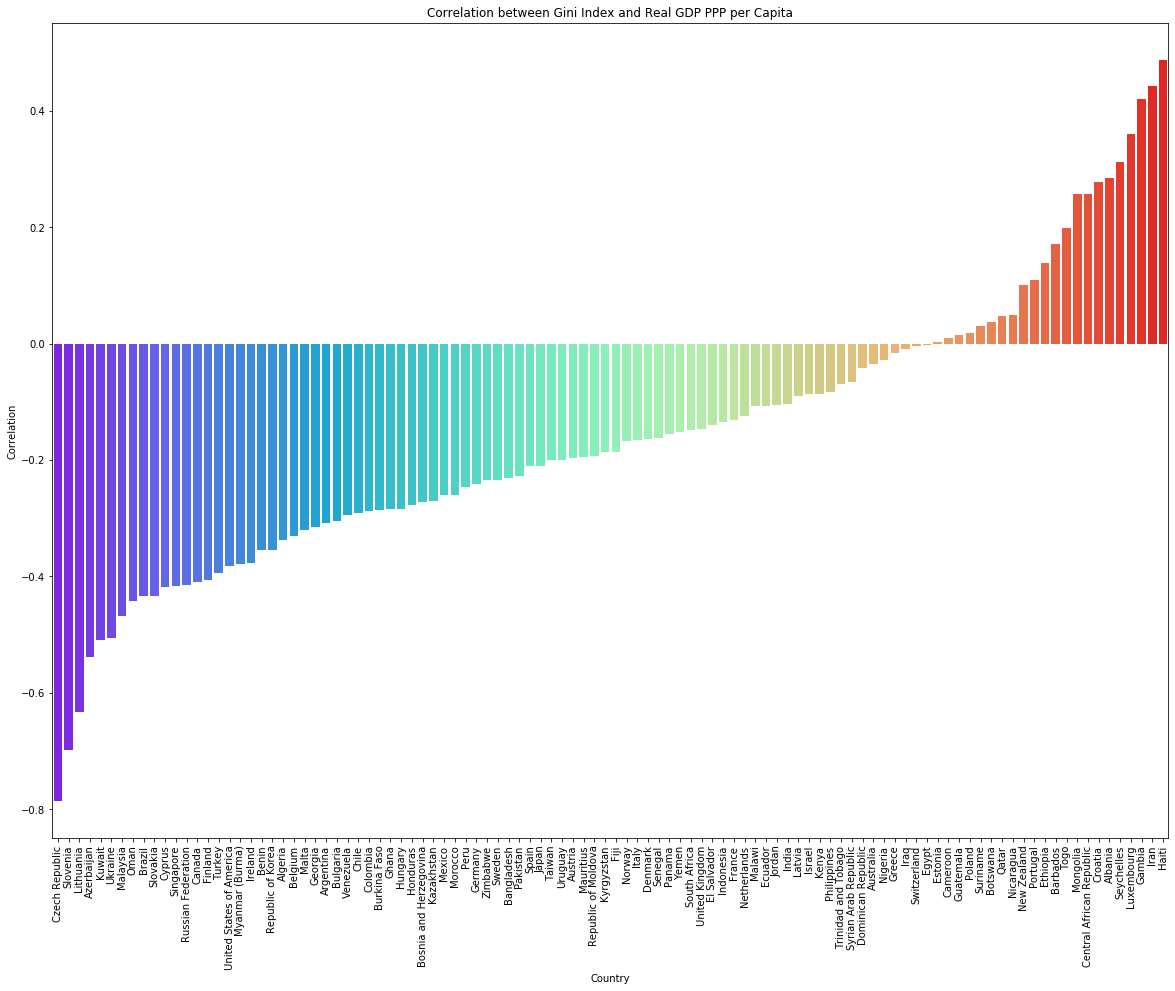

-0.1610812652572915

In [11]:
df4 = pd.DataFrame()
df4['country'] = countries
df4['cor'] = corrs
df4 = df4.sort_values(by=['cor'])

fig,ax = plt.subplots(figsize = (20,15))
sns.barplot(x = 'country',y ='cor', data = df4, palette = 'rainbow').set_title('Correlation between Gini Index and Real GDP PPP per Capita')
plt.ylabel('Correlation')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.show()
df4['cor'].mean()

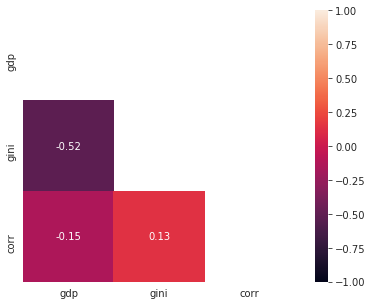

In [12]:
df42 = pd.DataFrame()
df42['gdp'] = gdp
df42['gini'] = gini
df42['corr'] = corrs

corr = df42.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, annot = True,vmin = -1,vmax = 1, square = True)


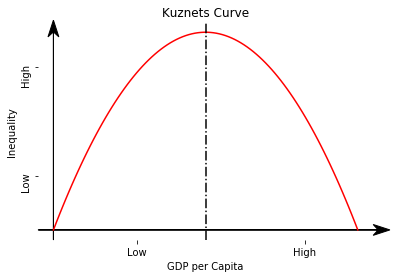

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 100 linearly spaced numbers
x = np.linspace(0,180,100)

# the function, which is y = x^2 here
y = -(x/3)**2 +20*x

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

# plot the function
plt.plot(x,y, 'r')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

plt.axvline(x=(xmin+xmax)/2,color='k',linestyle ='-.')

plt.xticks([(xmax-xmin)*0.25,(xmax-xmin)*0.75], ('Low', 'High'))
plt.yticks([(ymax-ymin)*0.25,(ymax-ymin)*0.75], ('Low', 'High'),rotation=90)

dps = fig.dpi_scale_trans.inverted()
bbox = ax.get_window_extent().transformed(dps)
width, height = bbox.width, bbox.height

# manual arrowhead width and length
hw = 1./20.*(ymax-ymin)
hl = 1./20.*(xmax-xmin)
lw = 1. # axis line width
ohg = 0.3 # arrow overhang

# compute matching arrowhead length and width
yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width
yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

ax.arrow(xmin, 0, xmax-xmin+10, 0., fc='k', ec='k', lw = lw,
         head_width=hw, head_length=hl, overhang = ohg,
         length_includes_head= True, clip_on = False)

ax.arrow(0, ymin, 0., ymax-ymin+10, fc='k', ec='k', lw = lw,
         head_width=yhw, head_length=yhl, overhang = ohg,
         length_includes_head= True, clip_on = False)


plt.xlabel('GDP per Capita')
plt.ylabel('Inequality')
plt.title('Kuznets Curve')

# show the plot
plt.show()